# How much should you price your Boston Airbnb?

Modelling Boston Airbnb prices

Maybe you have a place that you're fortunate enough to be able to potentially place on Airbnb but you're not sure if it's worth the hassle. With Airbnb making host listing data publicly available, we can break down the prices to understand what factors influence how much you can charge. We'll go through that here, geeking out on the methods used and giving you an easy guide for getting a rough idea for how much you might be able to charge if you have a place in Boston you can rent out.

Note: Airbnb also gives pricing tips based on much more sophisticated models than I can accomplish here ([more details](https://www.vrmintel.com/inside-airbnbs-algorithm/)). You'll need to start filling out your listing to get this info so this kernel will give you a very rough guide to get you started.

Alternatively, the findings from this kernel apply to those looking to understand which filters to play around with when trying to find a cheap (or expensive?) place, if you don't want to use the price filter on the search page ¯\_(ツ)_/¯.

## What data are we working with?

We're given three datasets:

- calendar.csv - listings with dates detailing whether they're available or not and how much they cost to rent on each date.
- listings.csv - lots of information about each listing including text descriptions, host details, number of bedrooms, bathrooms, location and more.
- reviews.csv - full text reviews for those listings that have been reviewed

We will mostly focus on `listings.csv` and pull date-sensitive prices from `calendar.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Show maximum 500 columns when displaying dataframes
pd.set_option('display.max_columns', 500)

# Use Seaborn standard design palette for plots
sns.set()

calendar = pd.read_csv('data/boston/calendar.csv')
listings = pd.read_csv('data/boston/listings.csv')

for dataset in [calendar, listings]:
    display(dataset.sample(3))

,listing_id,date,available,price
1268158,8607856,2017-03-28,f,NaN
1293899,14866400,2016-10-01,f,NaN
89806,12855343,2017-07-26,f,NaN


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
651,14857923,https://www.airbnb.com/rooms/14857923,20160906204935,2016-09-07,"2 Bedroom North End, Walk to Everything, Cozy!","First floor apartment, NO stairs! Two bedrooms...",NaN,"First floor apartment, NO stairs! Two bedrooms...",none,NaN,NaN,NaN,NaN,NaN,"- No parties, NO smoking, treat unit respectfully",https://a2.muscache.com/im/pictures/afb3b191-f...,https://a2.muscache.com/im/pictures/afb3b191-f...,https://a2.muscache.com/im/pictures/afb3b191-f...,https://a2.muscache.com/im/pictures/afb3b191-f...,21184200,https://www.airbnb.com/users/show/21184200,Paige,2014-09-10,"Boston, Massachusetts, United States",Hi and welcome to Boston! I'm a local Real Est...,within an hour,99%,81%,f,https://a2.muscache.com/im/pictures/b54817f1-c...,https://a2.muscache.com/im/pictures/b54817f1-c...,South Boston,30,30,"['email', 'phone', 'amex', 'reviews', 'kba']",t,t,"Endicott Street, Boston, MA 02113, United States",North End,North End,NaN,Boston,MA,02113,Boston,"Boston, MA",US,United States,42.365929,-71.056603,t,Apartment,Entire home/apt,5,1.0,2.0,2.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Pets Allowed""...",NaN,$260.00,NaN,NaN,$99.00,$60.00,4,$40.00,1,1125,today,NaN,16,39,69,344,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,strict,f,f,24,NaN
2588,7054058,https://www.airbnb.com/rooms/7054058,20160906204935,2016-09-07,Spacious Apt w/Patio & BBQ,This two bedroom apartment in Cleveland Circle...,My roommate and I share a huge two bedroom apa...,This two bedroom apartment in Cleveland Circle...,none,Cleveland Circle is a beautiful and safe neigh...,NaN,"The B, C, and D trains and restaurants are all...","You are welcome to enjoy the kitchen, living r...",NaN,Absolutely no smoking/drugs Keep the place as ...,https://a2.muscache.com/im/pictures/9f9eadea-6...,https://a2.muscache.com/im/pictures/9f9eadea-6...,https://a2.muscache.com/im/pictures/9f9eadea-6...,https://a2.muscache.com/im/pictures/9f9eadea-6...,7198154,https://www.airbnb.com/users/show/7198154,Marlo,2013-06-30,"Boston, Massachusetts, United States",I work as a Tech Consultant. My job lets me t...,within an hour,100%,95%,t,https://a2.muscache.com/im/pictures/a1e14687-e...,https://a2.muscache.com/im/pictures/a1e14687-e...,Allston-Brighton,3,3,"['email', 'phone', 'google', 'linkedin', 'amex...",t,t,"Sutherland Road, Boston, MA 02135, United States",Allston-Brighton,Brighton,NaN,Boston,MA,02135,Boston,"Boston, MA",US,United States,42.337170,-71.149654,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$150.00,NaN,Na

## Listings data clean up

In [2]:
print(f'The dataset contains {len(listings.id.unique())} from {len(listings.host_id.unique())} hosts.')

The dataset contains 3585 from 2181 hosts.


From the missingno matrix we see that we have a few features with only null values and some with mostly null values. We'll drop these along with any columns containing only one unique value and columns containing IDs or URL links.

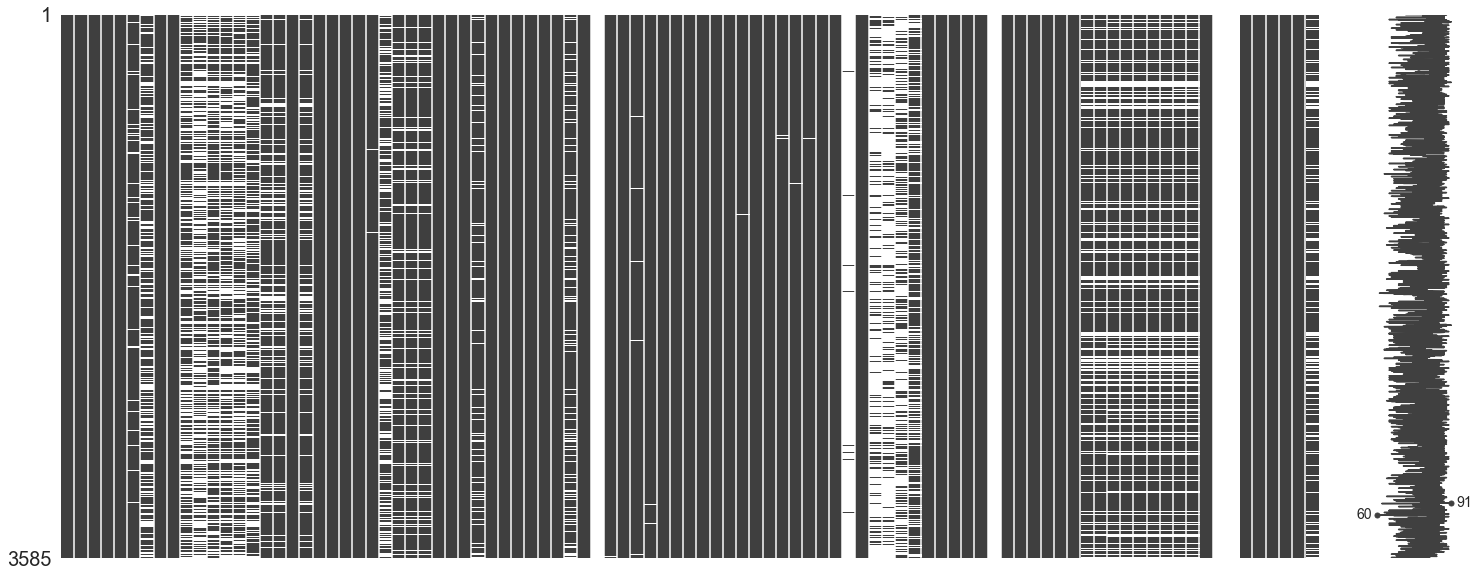

In [3]:
import missingno as msno

msno.matrix(listings);

In [4]:
# Note number of columns
before = len(listings.columns)

# Drop columns with all null values
all_null = len(listings.columns[listings.isnull().mean() == 1])
listings = listings.dropna(how='all', axis=1)

# Drop columns with more than 50% null values
more_than_50_null = listings.columns[listings.isnull().mean() > 0.5]
listings = listings.drop(more_than_50_null, axis=1)

# Drop columns with only one value
one_value_columns = [
    column for column in listings.columns if len(listings[column].unique()) == 1
]
listings.drop(one_value_columns, axis=1, inplace=True)

# Drop url, ID (except for 'id') and name columns
url_id_columns = listings.columns[listings.columns.str.contains('url|_id|name')]
listings = listings.drop(url_id_columns, axis=1)

print(
    '{} columns dropped:\
    \n\t{} columns with only null values\
    \n\t{} columns with more than 50% null values\
    \n\t{} columns with only one unique value\
    \n\t{} URL/ID/name columns'.format(
        before - len(listings.columns), all_null, len(more_than_50_null),
        len(one_value_columns), len(url_id_columns)
    )
)

29 columns dropped:    
	4 columns with only null values    
	5 columns with more than 50% null values    
	8 columns with only one unique value    
	12 URL/ID/name columns


Now we will drop a bunch of features for various reasons:
- they're covered by other features
- they are likely to add variance to the model by being colinear to our target variable
- they are almost completely one value

In [5]:
to_drop = [
    'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
    'host_verifications', 'host_has_profile_pic', 'street', 'neighbourhood',
    'city', 'zipcode', 'market', 'smart_location', 'latitude', 'longitude',
    'is_location_exact', 'cleaning_fee', 'guests_included', 'extra_people',
    'minimum_nights', 'maximum_nights', 'calendar_updated', 'availability_30',
    'bed_type', 'availability_60', 'availability_90', 'availability_365',
    'first_review', 'last_review', 'review_scores_rating', 
    'review_scores_accuracy', 'review_scores_cleanliness', 
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'require_guest_profile_picture', 
    'require_guest_phone_verification'
]

listings = listings.drop(to_drop, axis=1)

We are now going to convert text features to numerical ones.

- Summary and description features will be converted to a character count to see if a longer description helps.
- We will create a boolean local feature based on whether the host is from Boston or not
- `host_since` will be converted to a timedelta between an individual host's sign up date and the most recent host sign up
- `host_response_time` will be converted to a dummy variable
- % and $ signs will be stripped
- `amenities` column will be converted to a count of amenities listed
- Convert boolean t/f features to 1 or 0

In [6]:
# Define description features
description_features = ['summary', 'space', 'description', 'neighborhood_overview', 'transit', 'access', 'interaction', 'house_rules', 'host_about']

# Convert null values to empty strings
listings[description_features] = listings[description_features].apply(lambda col: col.fillna(''), axis=1)

# Convert description features to character counts
for column in listings[description_features]:
    listings[column] = listings[column].apply(lambda x: len(x))

# Convert host_since to datetime and create host_since_days timedelta feature
listings.host_since = pd.to_datetime(listings.host_since, yearfirst=True)
listings['host_since_days'] = (listings.host_since - listings.host_since.min()).dt.days

# Create is_local feature based on host_location
local_destination = 'Boston, Massachusetts, United States'
listings['is_local'] = listings.host_location.apply(
    lambda location: 1 if location==local_destination else 0
)

# Drop converted features
listings = listings.drop(['host_since', 'host_location'], axis=1)

# Map host_response_time values to numerical values
response_map = {
    np.nan: 0,
    'a few days or more': 1,
    'within a day': 2,
    'within a few hours': 3,
    'within an hour': 4
}
listings.host_response_time = listings.host_response_time.replace(response_map)

# Remove ['$', ',', '%'] and convert to float
str_to_float_columns = ['host_response_rate', 'host_acceptance_rate', 'price']
for column in str_to_float_columns:
#     listings[column] = listings[column].str.replace('$', '').str.replace('%', '').str.replace(',', '').astype(float)
    listings[column] = listings[column].apply(lambda value: re.sub(r'\$|,|%', '', str(value))).astype(float)
    
# Convert boolean t/f columns to 1/0 columns
boolean_columns = ['host_is_superhost', 'instant_bookable']
for column in boolean_columns:
    listings[column] = listings[column].apply(lambda val: True if val=='t' else False)
    
# Convert amenities to amenities_count
listings['amenities_count'] = listings.amenities.str.count(',')+1
listings = listings.drop('amenities', axis=1)

### Dropping listings without reviews

We want to understand what price to put for our new listing, we want to model this off "successful" listings. Therefore we're going to remove listings without a review. This also has the handy side effect of removing some listings that might define as outliers. Outliers can greatly impact a model's ability to predict pricing and account for variance but should not be removed for this reason alone. Data points may look like outliers but in our case, unless if they're an obvious mistake (e.g. a typo or other), then they are valid.

In [7]:
num_without_reviews = len(listings[listings.number_of_reviews==0])
percent_gone = num_without_reviews/len(listings)

print(f'{num_without_reviews} rows or {percent_gone:.2%} of rows dropped as having no reviews')

listings = listings[listings.number_of_reviews!=0]

756 rows or 21.09% of rows dropped as having no reviews


## Calendar data clean up

First off, with `price` as our target variable, we will drop any rows where the price is null. A quick glance at the data shows that this value is null when the listing is not availble for a given date.

Therefore we drop rows where price is null and drop the `available` column as this then contains only one value.

In [8]:
calendar.sample(2)

,listing_id,date,available,price
1263894,12409042,2016-10-01,f,NaN
515497,14442491,2017-05-09,f,NaN


In [9]:
# Drop any rows without the predictor value
calendar.dropna(subset=['price'], inplace=True)

# Convert price into a float
calendar.price = calendar.price.apply(
    lambda value: re.sub(r'\$|,', '', value)
).astype(float)

# Extract month from date string and rewrite values
calendar['month'] = calendar.date.apply(lambda value: value.split('-')[1])
calendar['month'] = calendar['month'].replace({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})

# Drop available and date columns
calendar = calendar.drop(['available', 'date'], axis=1)

calendar.sample(2)

,listing_id,price,month
1093777,3311675,52.0,Dec
926168,1110423,200.0,Dec


## Merge datasets

With both datasets cleaned up and transformed where needed, we can now merge the two. This will give us two `price` columns so we'll keep only the time-sensitive one coming from the calendar dataset.

In [10]:
df = pd.merge(
    listings, calendar, how='left',
    left_on='id', right_on='listing_id',
)

df = df.drop(['price_x', 'listing_id' ], axis=1)
df = df.rename({'price_y': 'price'}, axis=1)

# Drop any remaining rows without a price value
df = df.dropna(subset=['price'])

df.sample(3)

,id,summary,space,description,neighborhood_overview,transit,access,interaction,house_rules,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,host_since_days,is_local,amenities_count,price,month
298596,8704161,247,266,766,82,126,7,33,129,133,4,100.0,100.0,True,Beacon Hill,Apartment,Entire home/apt,4,2.0,2.0,2.0,24,10.0,False,strict,1,2.16,2517,0,21,500.0,Apr
85974,12302222,250,1000,1000,717,1000,0,274,0,0,3,98.0,55.0,False,Chinatown,Apartment,Entire home/apt,5,2.0,2.0,2.0,1,8.0,False,strict,136,0.77,2330,0,16,388.0,Dec
339979,6516588,280,291,1000,0,240,224,0,156,0,2,50.0,50.0,False,Fenway,Apartment,Entire home/apt,3,1.0,1.0,1.0,9,9.0,False,flexible,1,0.58,2385,1,6,175.0,Apr


## Exploring the data for trends

With some basic cleaning and feature engineering done, let's explore our dataset.

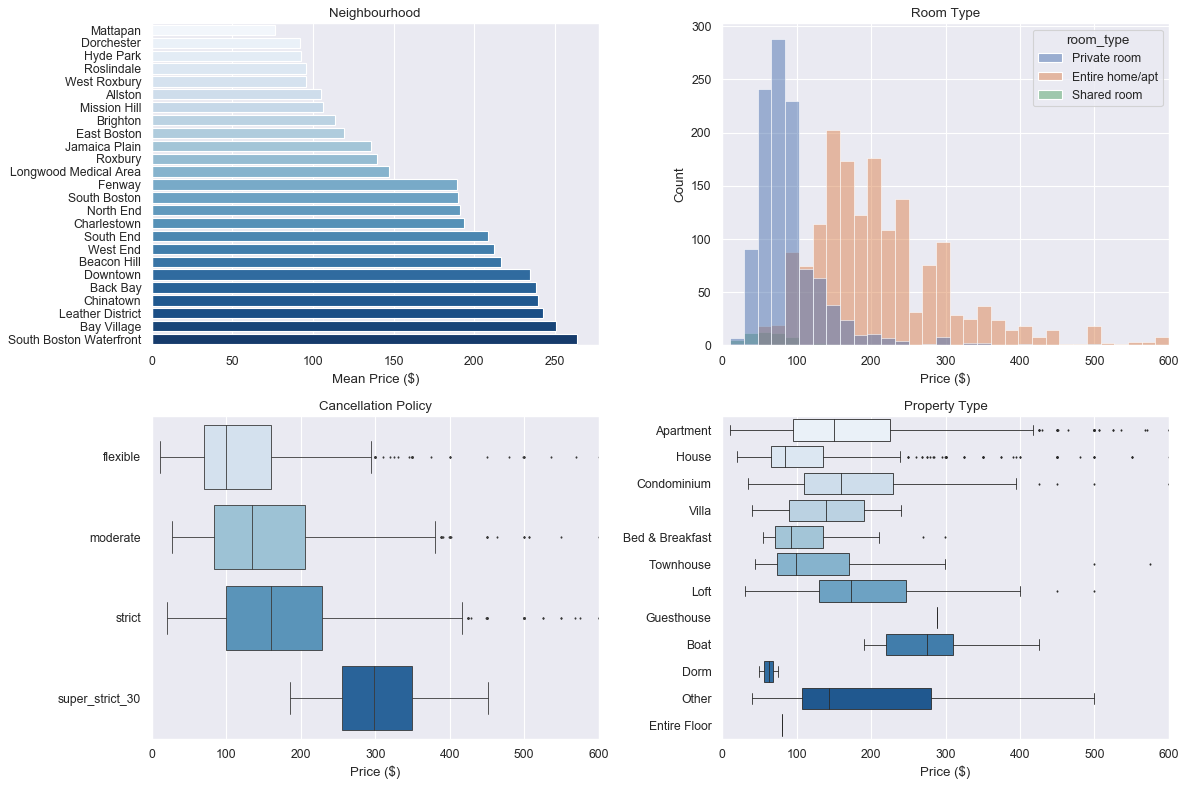

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), dpi=80)

# Neighbourhoods
neighbourhoods = listings.groupby('neighbourhood_cleansed').agg(
    {
        'price': np.mean
    }
).reset_index()
sns.barplot(
    x='price', y='neighbourhood_cleansed',
    data=neighbourhoods.sort_values('price'),
    orient='h',
    palette='Blues',
    ax=axs[0, 0]
)
axs[0, 0].set_title('Neighbourhood')
axs[0, 0].set_xlabel('Mean Price ($)')
axs[0, 0].set_ylabel('')

# Room type
sns.histplot(x='price', hue='room_type',
             data=listings, ax=axs[0, 1])
axs[0, 1].set_xlim(0, 600)
axs[0, 1].set_title('Room Type')
axs[0, 1].set_xlabel('Price ($)')

# Cancellation Policy
sns.boxplot(x='price', y='cancellation_policy', fliersize=1, linewidth=0.75,
            data=listings, palette='Blues', ax=axs[1, 0],
            order=['flexible', 'moderate', 'strict', 'super_strict_30'])
axs[1, 0].set_xlim(0, 600)
axs[1, 0].set_title('Cancellation Policy')
axs[1, 0].set_xlabel('Price ($)')
axs[1, 0].set_ylabel('')

# Property type
sns.boxplot(x='price', y='property_type', fliersize=1, linewidth=0.75,
            data=listings, palette='Blues', ax=axs[1, 1])
axs[1, 1].set_xlim(0, 600)
axs[1, 1].set_title('Property Type')
axs[1, 1].set_xlabel('Price ($)')
axs[1, 1].set_ylabel('')

plt.tight_layout()
plt.show();

In [12]:
df

,id,summary,space,description,neighborhood_overview,transit,access,interaction,house_rules,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,host_since_days,is_local,amenities_count,price,month
0,3075044,247,73,1000,355,538,132,172,403,77,4,100.0,100.0,False,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,36,9.0,True,moderate,1,1.3,1304,1,21,65.0,Aug
1,3075044,247,73,1000,355,538,132,172,403,77,4,100.0,100.0,False,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,36,9.0,True,moderate,1,1.3,1304,1,21,65.0,Aug
2,3075044,247,73,1000,355,538,132,172,403,77,4,100.0,100.0,False,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,36,9.0,True,moderate,1,1.3,1304,1,21,65.0,Aug
3,3075044,247,73,1000,355,538,132,172,403,77,4,100.0,100.0,False,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,36,9.0,True,moderate,1,1.3,1304,1,21,75.0,Aug
4,3075044,247,73,1000,355,538,132,172,403,77,4,100.0,100.0,False,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,36,9.0,True,moderate,1,1.3,1304,1,21,75.0,Aug
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527592,14603878,319,0,319,0,0,0,0,0,405,4,100.0,96.0,False,Charlestown,Apartment,Private room,2,1.0,1.0,1.0,2,7.0,False,strict,1,2.0,2754,0,8,59.0,Sep
527593,14603878,319,0,319,0,0,0,0,0,405,4,100.0,96.0,False,Charlestown,Apartment,Private room,2,1.0,1.0,1.0,2,7.0,False,strict,1,2.0,2754,0,8,59.0,Sep
527594,14603878,319,0,319,0,0,0,0,0,405,4,100.0,96.0,False,Charlestown,Apartment,Private room,2,1.0,1.0,1.0,2,7.0,False,strict,1,2.0,2754,0,8,59.0,Sep
527595,14603878,319,0,319,0,0,0,0,0,405,4,100.0,96.0,False,Charlestown,Apartment,Private room,2,1.0,1.0,1.0,2,7.0,False,strict,1,2.0,2754,0,8,59.0,Sep


## TODO

- Add plot for month vs. price
- Add impact of number of bedrooms/bathrooms
- Any impact of reviews/length of description

## Preprocessing step

As a final bit of preprocessing, we'll deal with missing values, encode categorical features and drop the `id` column.

5% of the rows contain missing data in one of the columns, mostly the `host_response_rate` and `host_acceptance_rate` columns. Even though it seems lazy, I see no reason why we shouldn't impute these missing values with the median rather than drop this 5% of the data.

In [13]:
# Dropping the extremely small subset of rows with no property_type
df = df.dropna(subset=['property_type']).copy()

# Imputing the mean for the remaining columns with null values
columns_with_null = df.columns[df.isnull().any()]
for column in columns_with_null:
    df[column] = df[column].fillna(df[column].median())

Finally we create dummies and drop the id column.

In [14]:
df = pd.get_dummies(df)
df = df.drop(['id'], axis=1)
df.sample(3)

,summary,space,description,neighborhood_overview,transit,access,interaction,house_rules,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,host_since_days,is_local,amenities_count,price,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
185062,70,796,867,0,0,0,0,21,866,3,89.0,45.0,False,2,1.0,1.0,1.0,22,8.0,False,79,0.35,241,0,6,209.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
184452,1,959,961,0,0,0,0,0,866,3,89.0,45.0,False,2,1.0,1.0,1.0,9,8.0,False,79,0.33,241,0,9,352.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
185980,167,1000,1000,129,38,0,40,37,866,3,89.0,45.0,False,2,1.0,1.0,1.0,22,9.0,False,79,0.28,241,0,12,251.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


## Modelling

We'll fit the data to a few different regression methods but the trusty Linear Regression may suit our needs best. The data may contain non-linear relationships that Linear Regression will not be able to capture but it does have the significant benefit of being easily interpretable and the coefficients provided by the model will allow us to easily get a rough idea for how much we should be charging for listings.

We'll then use a few tree-based ensemble methods. Tree-based methods give us great flexibility in their ability to describe non-linear relationships but they also tend to be very sensitive to small variations in the training data and, unconstrained, can lead to overfitting. This is why we'll use a few ensemble methods to reduce this tendency to overfit. Further, tree-based methods allow for measuring the importance of features in prediction.

### Linear Regression

With a moderate amount of features, we'll need to keep an eye on overfitting, scoring the model on both the training and test sets. If we were to detect any bias/variance then we can look at one of the regularisation methods.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop('price', axis=1)
y = df.price

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# R-squared score
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# RMSE
rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
rmse_test = (mean_squared_error(y_test, y_pred_test))**0.5

print(
    'Train R-squared: {:.3f}\tTrain RMSE: ${:.2f}\
    \nTest R-squared: {:.3f}\tTest RMSE: ${:.2f}'
    .format(r2_train, rmse_train, r2_test, rmse_test)
)

Train R-squared: 0.600    
Test R-squared: 0.608    
Train RMSE: $96.86    
Test RMSE: $95.53


Our model spits out an R-squared score of 60% meaning that we can account for around 60% of the variance using our features using Linear Regression. We also need to bear in mind the significant standard deviation of the residuals represented by the $97 root-mean-squared-error. Predictions made with the model have a large error margin.

Now let's have a look at the coefficients.

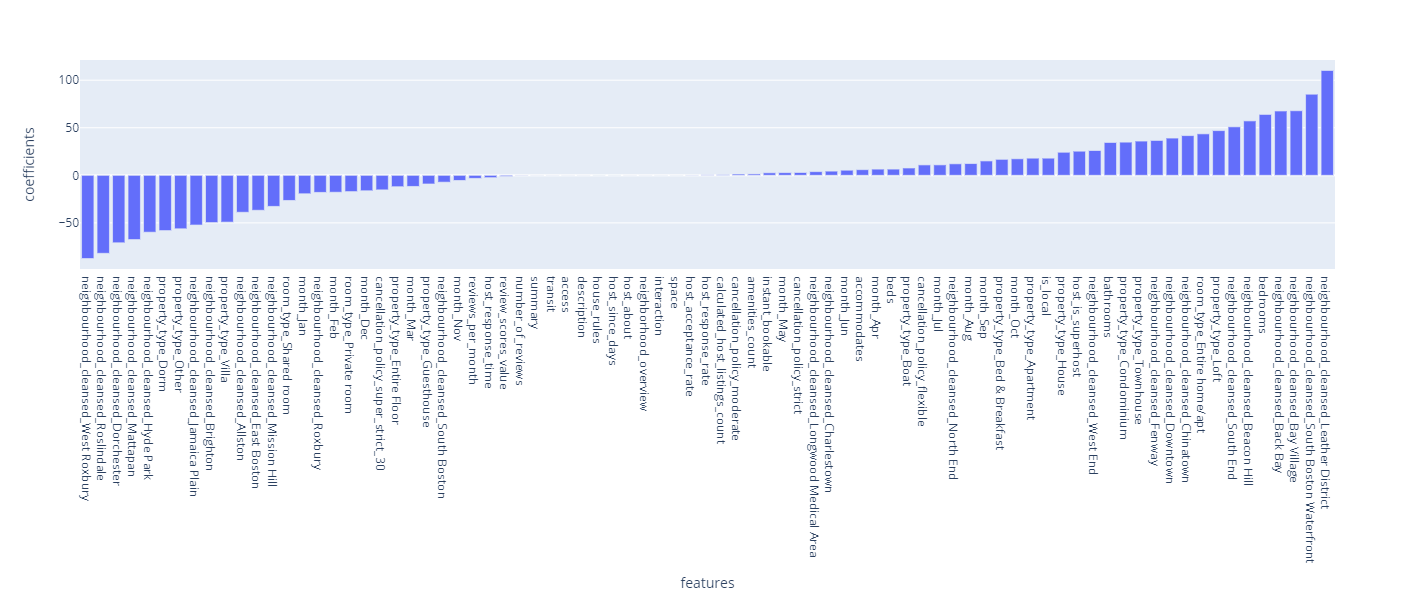

In [23]:
feature_importance = pd.DataFrame(
    {'features': X.columns, 'coefficients': model.coef_}
).sort_values(by='coefficients')
feature_importance['features'] = feature_importance['features']

import plotly.express as px
fig = px.bar(x='features', y='coefficients', data_frame=feature_importance, height=600)
fig.show();

With this birds eye view of the coefficients we can see quite a few features having little to no impact on the price according to our linear regression model. Notable features that don't influence the price here:

- the length of the descriptions provided for different aspects of the listing such as the summary, information about the space, transit, etc.
- details about the host such as their response time/rate and number of listings
- number of reviews or the average rating given to a listing

Below we pull out the features deemed relevant by the model in predicting the price. The neighbourhood, property type and room type, alongside the number of rooms and properties stand out as key features in deciding the price.

The way to read this would be to go through the different features and add/subtract the coefficients together to get a rough idea for what price to put your Airbnb up for. To this you then need to add the **'intercept' of the model**, in our case $-\$86$. That means you need to subtract $\$86$ from the final price. The intercept is negative because we have certain features such as bedrooms which start at 1 instead of 0.

For example, say I have a two bed apartment in South End that I want to rent out in January. I would calculate

- $+\$50$ for the South End neighbourhood
- $+\$20$ because it's an apartment
- $-\$20$ since January is a cheap month
- $+\$0$ because I want to use a moderate cancellation policy
- $+\$42$ since I'll rent out the whole apartment
- $+2\times\$63$ for the two bedrooms
- $+\$35$ for the one bathroom
- $+3\times\$3$ for the three beds (there's a sofa bed)
- $+6\times\$3$ since the place accommodates 6 people
- $-\$86$ for the intercept

Therefore the model says I should put the place up for a price around $\$194$. Again, bearing in mind the potential error margin here, I might think that my apartment is in a particularly nice part of South End and want to push the price up a bit. Maybe it's a bit of a cheek calling it a two-bed and knock a few dollars off.

Feel free to go through the features here to get a rough idea of how much you might price your property.

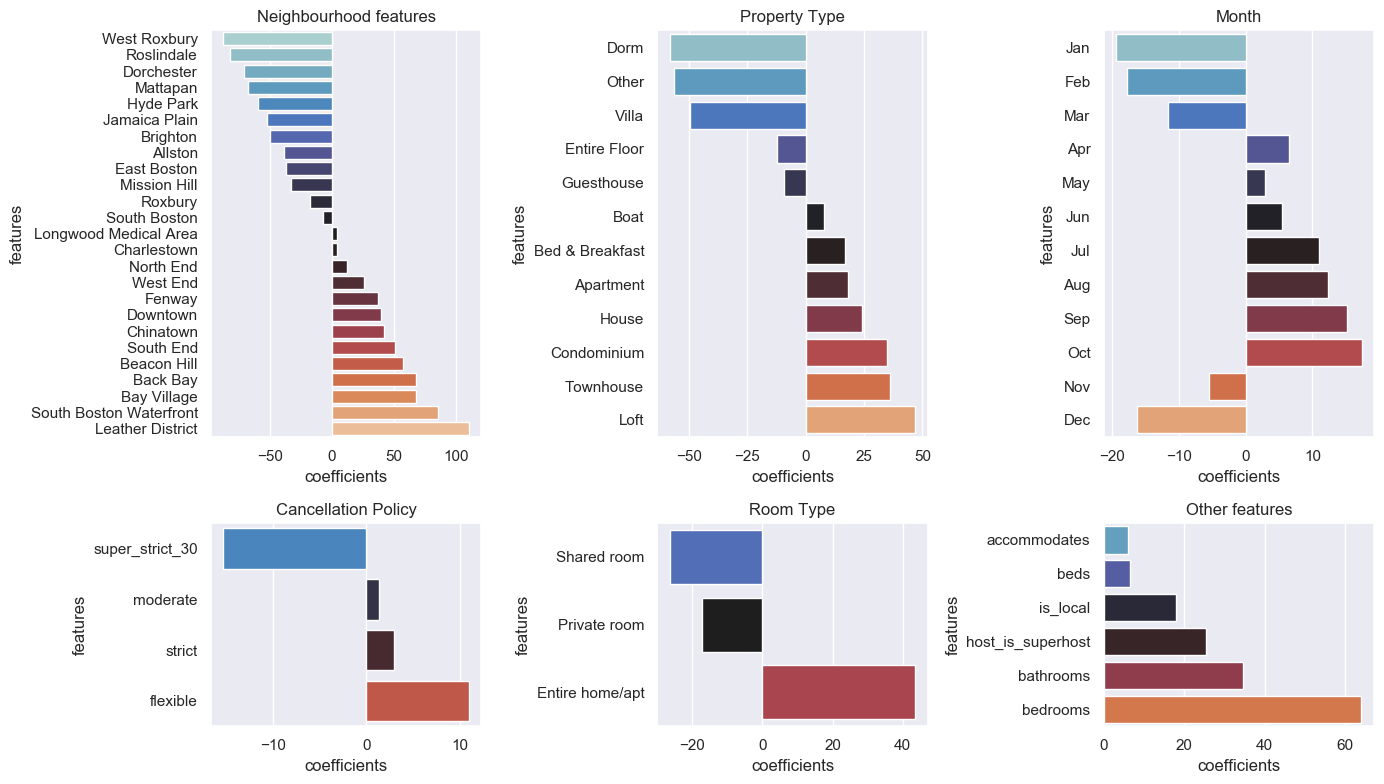

In [27]:
color_palette = 'icefire'
fig, axs = plt.subplots(2, 3, figsize=(14, 8), dpi=100,
                        gridspec_kw = {'height_ratios': [4, 2]})

# Neighbourhoods
_ = feature_importance[feature_importance.features.str.contains('neighbourhood_cleansed')].copy()
_.features = _.features.str.lstrip('neighbourhood_cleansed_')
sns.barplot(
    y='features', x='coefficients',
    orient='h', data=_,
    palette=color_palette,
    ax=axs[0, 0]
)
axs[0, 0].set_title('Neighbourhood features')

# Property type
_ = feature_importance[feature_importance.features.str.contains('property_type')].copy()
_.features = _.features.str.lstrip('property_type_')
sns.barplot(
    y='features', x='coefficients',
    orient='h', data=_,
    palette=color_palette,
    ax = axs[0, 1]
);
axs[0, 1].set_title('Property Type')

# Month plot
_ = feature_importance[feature_importance.features.str.contains('month_')].copy()
_.features = _.features.str.lstrip('month_')
_.features = _.features.astype('category')
sorter = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
_['features'].cat.set_categories(sorter, inplace=True)
sns.barplot(
    y='features', x='coefficients',
    orient='h', data=_,
    palette=color_palette,
    ax = axs[0, 2]
);
axs[0, 2].set_title('Month')

# Cancellation policy
_ = feature_importance[feature_importance.features.str.contains('cancellation')].copy()
_.features = _.features.str.lstrip('cancellation_policy_')
sns.barplot(
    y='features', x='coefficients',
    orient='h', data=_,
    palette=color_palette,
    ax = axs[1, 0]
);
axs[1, 0].set_title('Cancellation Policy')

# Room type
_ = feature_importance[feature_importance.features.str.contains('room_type')].copy()
_.features = _.features.str.lstrip('room_type_')
sns.barplot(
    y='features', x='coefficients',
    orient='h', data=_,
    palette=color_palette,
    ax = axs[1, 1]
);
axs[1, 1].set_title('Room Type')

# Bedrooms, Bathrooms, etc.
other  = feature_importance[feature_importance.features.isin(['bedrooms', 'bathrooms', 'beds', 'accommodates', 'host_is_superhost', 'is_local'])].copy()
sns.barplot(
    y='features', x='coefficients',
    orient='h', data=other,
    palette=color_palette,
    ax = axs[1, 2]
);
axs[1, 2].set_title('Other features')

fig.tight_layout()
plt.show();

There are some clear drawbacks to this model. For one thing, it's possible to plug in data to return a negative listing price implying that you should pay someone to come and stay in your dorm in West Roxbury in December. However, whilst Linear Regression in this case may not be the best method to accurately predict listing prices, it does provide an easily interpeted model that can be used (at least in some form) without even needing to use anything other than a pen and paper.

We'll now look at some ensemble methods to see if we can account for more of the variation in the data.

### Ensemble methods

As mentioned, ensembled methods allow us leverage the flexibility of (in this case) tree-based models whilst reducing their tendency to memorise noise.

#### Random Forests

Random Forests is one of the most powerful Machine Learning algorithms, despite its simplicity. It is an ensemble of Decision Trees, taking the average prediction from multiple individual trees all trained on a different random subset of the training data. Let's see how it does on our data.

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
rmse_test = (mean_squared_error(y_test, y_pred_test))**0.5

print(
    'Train R-squared: {:.3f}\tTrain RMSE: ${:.2f}\
    \nTest R-squared: {:.3f}\tTest RMSE: ${:.2f}'
    .format(r2_train, rmse_train, r2_test, rmse_test)
)

Train R-squared: 0.935	Train RMSE: $39.03    
Test R-squared: 0.937	Test RMSE: $38.17


Over 90% of the variance accounted for using Random Forests and with no sign of overfitting! Note though the sizable residual error standard deviation. There is stil a room for error even with so much of the variability in our dataset accounted for.

We'll look at the key features driving the prediction in a moment. First we'll look at a second ensemble method.

#### XGBoost

XGBoost stands for Extreme Gradient Boosting, a "boosting" ensemble method that works by sequentially adding predictors to an ensemble, each one correcting its predecessor. Another popular boosting method is AdaBoost, which stands for Adaptive Boosting.

In [51]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
rmse_test = (mean_squared_error(y_test, y_pred_test))**0.5

print(
    'Train R-squared: {:.3f}\tTrain RMSE: ${:.2f}\
    \nTest R-squared: {:.3f}\tTest RMSE: ${:.2f}'
    .format(r2_train, rmse_train, r2_test, rmse_test)
)

Train R-squared: 0.902	Train RMSE: $47.99    
Test R-squared: 0.905	Test RMSE: $46.91


We've chosen tree-based models here not only for their flexibility but also their ability to assess feature importance. Feature importance is measured by how much the tree nodes use a particular feature to predict prices. Scikit-Learn scales the results so that the sum of all importances is equal to 1.

Let's see the top most important features according to the two ensemble methods.

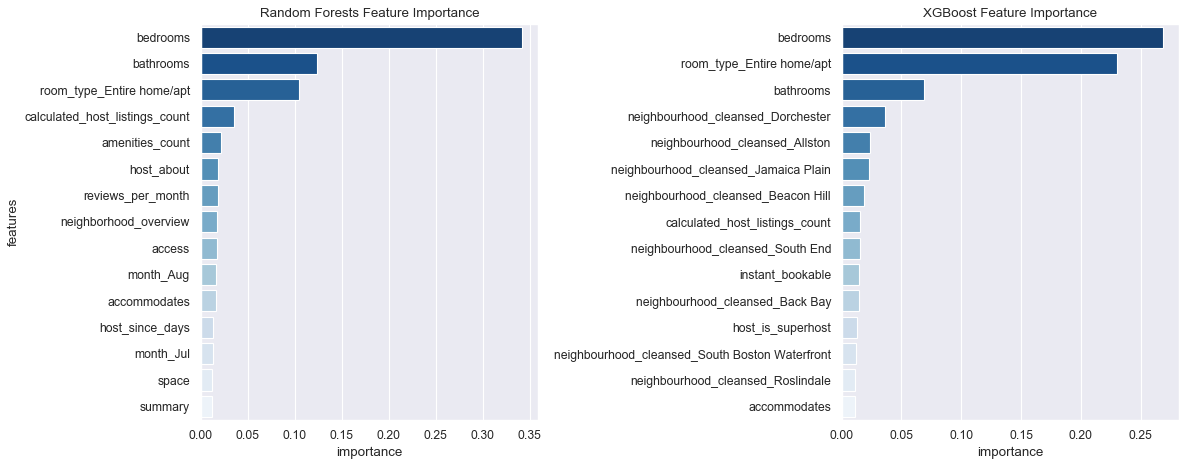

In [73]:
# Random Forest feature importance
feature_importance_rf = pd.DataFrame(
    {'features': X.columns, 'importance': rf.feature_importances_}
).sort_values(by='importance', ascending=False)

# XGBoost feature importance
feature_importance_xgb = pd.DataFrame(
    {'features': X.columns, 'importance': xgb.feature_importances_}
).sort_values(by='importance', ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
sns.barplot(
    x='importance', y='features', data=feature_importance_rf.head(15),
    orient='h', palette='Blues_r', ax=axs[0]
)
axs[0].set_title('Random Forests Feature Importance')
sns.barplot(
    x='importance', y='features', data=feature_importance_xgb.head(15),
    orient='h', palette='Blues_r', ax=axs[1]
);
axs[1].set_title('XGBoost Feature Importance')
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

Both ensemble methods are aligned that the number of bedrooms, bathrooms and whether the listing is an entire home/apt or not are the most important features. For both models, these features account for 57% of the importance. The rest of the features attribute small importances to the models.

## Conclusion

### Avoiding complexity

Through the models chosen and with the task at hand, we've managed to avoid some extra steps here in making our predictions. We did not need to scale our data since we used Linear Regression rather than one of the regularized methods and scaling did not impact the ensemble methods. Further, since we are only providing guidelines, we did not need to optimize our models with hyperparameter tuning. Our ensemble methods scored well enough by most standards without the added complexity.


### That _Je Ne Sais Quoi_

The models have given us some sensible guidelines for choosing how much to put a place up for on Airbnb but in each case, there was a sizeable error margin.

While our models do a great job at generalizing prices based on features, each listing is unique and what makes a traveller decide that your place is worth the money comes down to many features we won't be able to capture, although Airbnb do their best with their model.

